In [51]:
# SETUP
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
import numpy as np
import json
import requests
import pandas as pd

# METRICS TABLE
# Define custom decorator to automatically calculate metric based on key
metrics = {}
metric = lambda f: metrics.setdefault(f.__name__, f)

@metric
def ap(results, relevant):
    """Average Precision"""
    precision_values = []
    precision_values = [
        len([
            doc 
            for doc in results[:idx]
            if doc in relevant
        ]) / idx 
        for idx, _ in enumerate(results, start=1)
    ]

    return sum(precision_values)/max(len(precision_values),1)

@metric
def p10(results, relevant, n=10):
    """Precision at N"""
    return len([doc for doc in results[:n] if doc in relevant])/n

# Define metrics to be calculated
evaluation_metrics = {
    'ap': 'Average Precision',
    'p10': 'Precision at 10 (P@10)'
}

class Evaluate:
    
    def __init__(self, results, relevant):
        self.results = results
        self.relevant = relevant
        # then remove
        print('Results: ', results)
        print('Relevant: ', relevant)
        print(f'Precision at 10: {self.calculate_metric("p10")}')
        print(f'Average Precision: {self.calculate_metric("ap")}')
        
    def calculate_metric(self,metric):
        return metrics[metric](self.results, self.relevant)
    
    def export_metrics(self, file_path):
        df = pd.DataFrame([['Metric', 'Value']] + 
                          
            [[metric, self.calculate_metric(metric)] for metric in evaluation_metrics.keys()])

        with open(f'{file_path}/evaluation.tex', 'w+') as f:
            f.write(df.to_latex())
            
    def export_average_precision(self, file_path):
        average_precision = self.calculate_metric('ap')
        with open(f'{file_path}/average_precision.txt', 'w+') as f:
            f.write(str(average_precision))
            
    def precision_recall(self, label= None):
        
        if not self.results: return
        
        # Get precision and recall values
        precision_values = [
            len([
                doc 
                for doc in self.results[:idx]
                if doc in self.relevant
            ]) / idx 
            for idx, _ in enumerate(self.results, start=1)
        ]
        
        recall_values = [
            len([
                doc for doc in self.results[:idx]
                if doc in self.relevant
            ]) / len(self.relevant)
            for idx, _ in enumerate(self.results, start=1)
        ]
        
        precision_recall_match = {k: v for k,v in zip(recall_values, precision_values)}
        
        recall_values.extend([step for step in np.arange(0.1, 1.1, 0.1) if step not in recall_values])
        recall_values = sorted(set(recall_values))
        
        # Extend matching dict to include these new intermediate steps
        for idx, step in enumerate(recall_values):
            if step not in precision_recall_match:
                if recall_values[idx-1] in precision_recall_match:
                    precision_recall_match[step] = precision_recall_match[recall_values[idx-1]]
                else:
                    precision_recall_match[step] = precision_recall_match[recall_values[idx+1]]

        disp = PrecisionRecallDisplay([precision_recall_match.get(r) for r in recall_values], recall_values)
        disp.plot(name=label)
        plt.savefig('precision_recall.pdf')
        precision = [precision_recall_match.get(r, 0) for r in recall_values]
        recall = recall_values
        return precision, recall





In [24]:
queries = {
    # i will kill you
    "basic": "http://localhost:8983/solr/simple_conversations/select?debug.explain.structured=false&debugQuery=false&defType=edismax&fl=*%2C%20%5Bchild%5D%2C%20score&indent=true&pf=transcript%5E10.0%20movie%5E5.0%20actors%5E2.5%20characters%5E2.5&q.op=OR&q=I%20will%20kill%20you&qf=transcript%5E10.0%20movie%5E5.0%20actors%5E2.5%20characters%5E2.5&rows=10&sort=score%20desc%2C%20imdb_votes%20desc%2C%20imdb_rating%20desc&useParams=&wt=json",
    "complex": "http://localhost:8983/solr/complex_conversations/select?debug.explain.structured=false&debugQuery=false&defType=edismax&fl=*%2C%20%5Bchild%5D%2C%20score&indent=true&pf=transcript%5E10.0%20movie%5E5.0%20actors%5E2.5%20characters%5E2.5&q.op=OR&q=I%20will%20kill%20you&qf=transcript%5E10.0%20movie%5E5.0%20actors%5E2.5%20characters%5E2.5&rows=10&sort=score%20desc%2C%20imdb_votes%20desc%2C%20imdb_rating%20desc&useParams=&wt=json"
}

QRELS_FILE = "./q1/qrels.txt"
folder = "./q1/"

In [34]:
queries = {
    # Freddy Krueger Nightmare on Elm Street
    "basic":"http://localhost:8983/solr/simple_conversations/select?debug.explain.structured=false&debugQuery=false&defType=edismax&fl=*%2C%20%5Bchild%5D%2C%20score&indent=true&pf=transcript%5E10.0%20movie%5E5.0%20actors%5E2.5%20characters%5E2.5&q.op=OR&q=Freddy%20Krueger%20Nightmare%20on%20Elm%20Street&qf=transcript%5E10.0%20movie%5E5.0%20actors%5E2.5%20characters%5E2.5&rows=10&sort=score%20desc%2C%20imdb_votes%20desc%2C%20imdb_rating%20desc&useParams=&wt=json",
    "complex":"http://localhost:8983/solr/complex_conversations/select?debug.explain.structured=false&debugQuery=false&defType=edismax&fl=*%2C%20%5Bchild%5D%2C%20score&indent=true&pf=transcript%5E10.0%20movie%5E5.0%20actors%5E2.5%20characters%5E2.5&q.op=OR&q=Freddy%20Krueger%20Nightmare%20on%20Elm%20Street&qf=transcript%5E10.0%20movie%5E5.0%20actors%5E2.5%20characters%5E2.5&rows=10&sort=score%20desc%2C%20imdb_votes%20desc%2C%20imdb_rating%20desc&useParams=&wt=json",
}



QRELS_FILE = "./q2/qrels.txt"
folder = "./q2/"


In [32]:
queries = {
    # hacking security 
    "basic":"http://localhost:8983/solr/simple_conversations/select?debug.explain.structured=false&debugQuery=false&defType=edismax&fl=*%2C%20%5Bchild%5D%2C%20score&indent=true&pf=transcript%5E10.0%20movie%5E5.0%20actors%5E2.5%20characters%5E2.5&q.op=OR&q=hacking%20security&qf=transcript%5E10.0%20movie%5E5.0%20actors%5E2.5%20characters%5E2.5&rows=10&sort=score%20desc%2C%20imdb_votes%20desc%2C%20imdb_rating%20desc&useParams=&wt=json",
    "complex":"http://localhost:8983/solr/complex_conversations/select?debug.explain.structured=false&debugQuery=false&defType=edismax&fl=*%2C%20%5Bchild%5D%2C%20score&indent=true&pf=transcript%5E10.0%20movie%5E5.0%20actors%5E2.5%20characters%5E2.5&q.op=OR&q=hacking%20security&qf=transcript%5E10.0%20movie%5E5.0%20actors%5E2.5%20characters%5E2.5&rows=10&sort=score%20desc%2C%20imdb_votes%20desc%2C%20imdb_rating%20desc&useParams=&wt=json",
}

QRELS_FILE = "./q3/qrels.txt"
folder = "./q3/"

234002:fletch:Sure. Will you kill me? 
------------------
83792:minority report:No. You're not gonna kill me? 
------------------
139208:the thing:Then kill me. Then I'll have to kill you. You ain't tying me up. 
------------------
146233:twin peaks: fire walk with me:I want you to kill for me. No. Never. You'll have to kill me. I want you to kill for me. No. 
------------------
176249:beloved:I WILL PROTECT YOU. YOU HURT ME. 
------------------
79858:the life of david gale:No believe me I'm gonna kill him! No I'm gonna kill him -- 
------------------
96798:nick of time:You fucked up. I killed you. 
------------------
83799:minority report:Who said I would? You're supposed to kill me.  He said you would. 
------------------
73057:kalifornia:No sir. You think I'm goin' to kill you. Well that'd make me a liar then wouldn't it? 
------------------
209677:dark city:Please... Shut up! Don?�t kill me! 
------------------
Results:  ['234002', '83792', '139208', '146233', '176249', '79858', '9

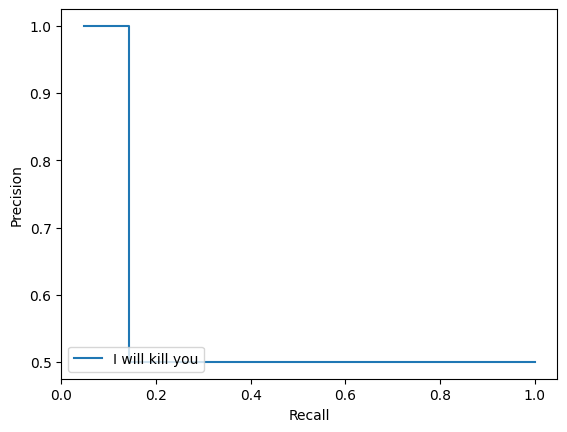

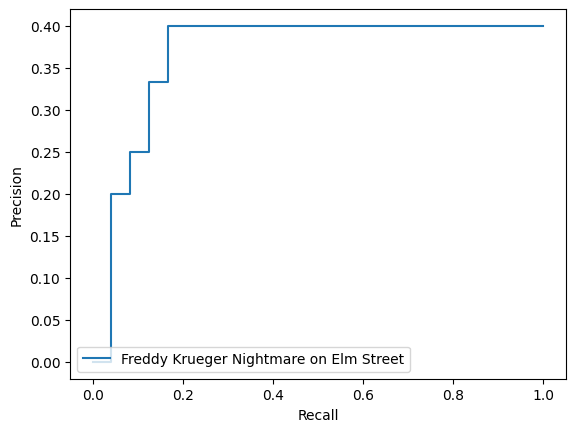

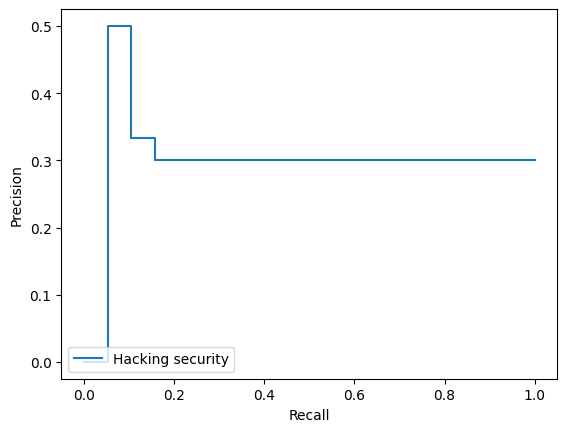

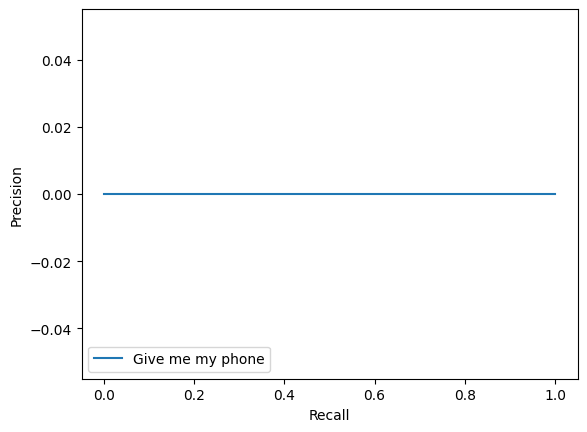

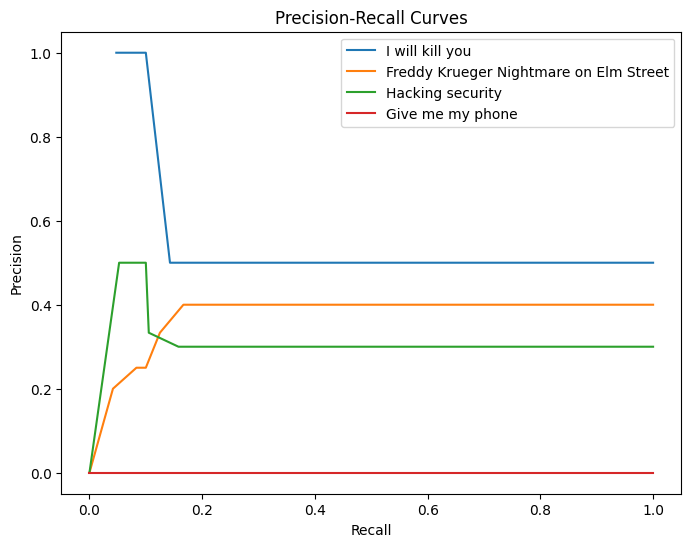

In [63]:
import requests
import os
from sentence_transformers import SentenceTransformer

def text_to_embedding(text):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embedding = model.encode(text, convert_to_tensor=False).tolist()
    
    # Convert the embedding to the expected format
    embedding_str = "[" + ",".join(map(str, embedding)) + "]"
    return embedding_str

def solr_knn_query(endpoint, collection, embedding, query):
    url = f"{endpoint}/{collection}/select"

    data = {
        "q": f"{{!knn f=vector topK=10}}{embedding}",
        "fl": "id,movie,score,transcript",
        "rq": "{!rerank reRankQuery=$rqq reRankDocs=50 reRankWeight=3}",
        "rqq": "{!edismax qf=transcript pf=transcript}" + query ,
        "rows": 10,
        "wt": "json"
    }
    
    headers = {
        "Content-Type": "application/x-www-form-urlencoded"
    }
    
    response = requests.post(url, data=data, headers=headers)
    response.raise_for_status()
    return response.json()

queries = ["I will kill you", "Freddy Krueger Nightmare on Elm Street", "Hacking security", "Give me my phone"]
qrels = ["./q1/qrels.txt", "./q2/qrels.txt", "./q3/qrels.txt", "./q3/qrels.txt" ]
solr_endpoint = "http://localhost:8983/solr"
collection = "semantic_conversations"

results_dict = {}
resultGraphs = {}

j = 0

for query in queries:
    embedding = text_to_embedding(query)

    relevant = list(map(lambda el: el.strip(), open(qrels[j]).readlines()))
    j += 1
    try:
        results = solr_knn_query(solr_endpoint, collection, embedding, query)
        results = results.get("response",{}).get("docs",[])
        results_transcript = [x['transcript'] for x in results]
        results_movie = [x['movie'] for x in results]
        results = [x['id'] for x in results]
        
        for i,doc in enumerate(results_transcript):
            print(results[i] + ":" + results_movie[i] + ":" + doc)
            print('------------------')
        
        results_dict[query] = results
        
        evaluation = Evaluate(results, relevant)
        

        precision,recall = evaluation.precision_recall(label = query)
        resultGraphs[query] = {'precision': precision, 'recall': recall}
        
    except requests.HTTPError as e:
        print(e)
        print(e.response.text)


plt.figure(figsize=(8, 6))

for query, data in resultGraphs.items():
    precision = data['precision']
    recall = data['recall']
    plt.plot(recall, precision, label=query)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.show()        

In [52]:
import os

# Read qrels to extract relevant documents
relevant = list(map(lambda el: el.strip(), open(QRELS_FILE).readlines()))

results_dict = {}
resultGraphs = {}

for query, url in queries.items():
    results = requests.get(url).json()['response']['docs']
    
    results_transcript = [x['transcript'] for x in results]
    results = [x['id'] for x in results]

    
    for i,doc in enumerate(results_transcript):
        print(results[i] + ":" + doc)
        print('------------------')
        
    results_dict[query] = results
    
    evaluation = Evaluate(results, relevant)
    path = f'{folder}{query}'
    
    if not os.path.exists(path):
        os.makedirs(path)
        
    evaluation.export_metrics(path)
    precision,recall = evaluation.precision_recall(label=query)
    resultGraphs[query] = {'precision': precision, 'recall': recall}
    evaluation.export_average_precision(path)
    
for i in range(10):
    basic_results = ('R' if results_dict['basic'][i] in relevant else 'NR') if results_dict['basic'] and i < len(results_dict['basic']) else 'N/A'
    complex_results = ('R' if results_dict['complex'][i] in relevant else 'NR') if results_dict['complex'] and i < len(results_dict['complex']) else 'N/A'
    
    print(f'{i+1} & {basic_results} & {complex_results}\\\\')
    

plt.figure(figsize=(8, 6))

for query, data in resultGraphs.items():
    precision = data['precision']
    recall = data['recall']
    plt.plot(recall, precision, label=query)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.show()

AttributeError: 'list' object has no attribute 'items'